In [1]:
import pandas as pd
import IPython.display as display
import numpy as np
import os,random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

2.16.1


In [2]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git Resources/Image-Classification-CNN-and-VGG

fatal: destination path 'Resources/Image-Classification-CNN-and-VGG' already exists and is not an empty directory.


## Prepare Data

In [3]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64

# Create data frame of image details
def get_pathframe(path):
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'dog':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

df = get_pathframe("Resources/Image-Classification-CNN-and-VGG/dataset/dataset/")

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


,filename,category,paths
24995,dog.8381.jpg,1,Resources/Image-Classification-CNN-and-VGG/dat...
24996,cat.10874.jpg,0,Resources/Image-Classification-CNN-and-VGG/dat...
24997,dog.11609.jpg,1,Resources/Image-Classification-CNN-and-VGG/dat...
24998,dog.10472.jpg,1,Resources/Image-Classification-CNN-and-VGG/dat...
24999,cat.341.jpg,0,Resources/Image-Classification-CNN-and-VGG/dat...


In [4]:
# Load, Resize, and Normalize images
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0
  return image

def convert_to_tensor(df):
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  onehot_label = tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)
  return image_ds,label_ds

X,Y = convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


Photo 0: dog
Photo 1: cat
Photo 2: cat
Photo 3: dog
Photo 4: cat


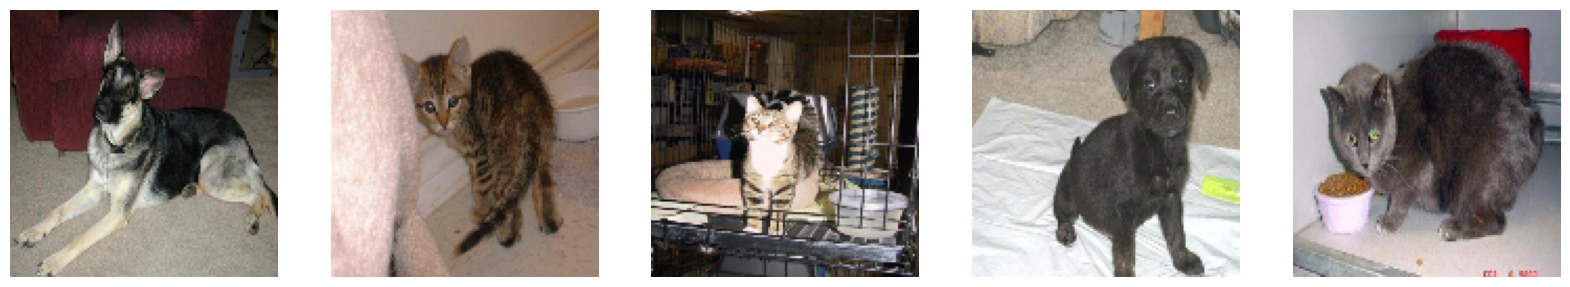

In [5]:
## Check the data
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

image_check=[]
for n, image in enumerate(X.take(5)):
  image_check.append(image)

label_check=[]
for n, label in enumerate(Y.take(5)):
  label_check.append(label)

plotimages(image_check)

for n, label in enumerate(label_check):
    if label.numpy() == 1:
        print(f"Photo {n}: dog")
    elif label.numpy() == 0:
        print(f"Photo {n}: cat")

In [6]:
dataset = tf.data.Dataset.zip((X,Y))
dataset_train = dataset.take(20000).shuffle(2000)
dataset_test = dataset.skip(20000)

dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train


<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

## Build the Network

In [7]:
def My_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT):

  model = tf.keras.models.Sequential()
  model.add(layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [8]:
model=My_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,705 (8.10 MB)

 Trainable params: 2,122,705 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training Loop

In [ ]:
hist=model.fit(dataset_train, epochs=20, validation_data=dataset_test)
model.save("C:/Users/caleb/OneDrive/Documents/Coding Projects/Current Projects/Deep-Learning/Resources/Image-Classification-CNN-and-VGG/models/My_CNNmodel.keras")

In [9]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1, 5), labels=range(1, len(model_history.history[acc])+1, 5))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1, 5), labels=range(1, len(model_history.history[acc])+1, 5))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#plot_model_history(hist)

## Evaluation (Initial Model)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Evaluate performance on validation set
loss, accuracy = model.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

y_preds = []
y_labels = []
y_features = []

# Loop through dataset_test to make predictions and store labels for comparison
for features, labels in dataset_test:
    predictions = model.predict(features, verbose=0)
    y_preds.extend([1 if pred > 0.5 else 0 for pred in predictions.flatten()])
    y_labels.extend(labels.numpy().flatten())
    y_features.extend(features.numpy())

# Create confusion matrix
confusion_mtx = confusion_matrix(y_labels, y_preds)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
plotimages(y_features[:5])
print("Predictions:", y_preds[:5])
print("True Labels:", y_labels[:5])

plotimages(y_features[5:10])
print("Predictions:", y_preds[5:10])
print("True Labels:", y_labels[5:10])

In [ ]:
report = classification_report(y_labels, y_preds, target_names=['0','1'])
print(report)


##### The simple CNN seems to be overfitting on the test data pretty dramatically. Testing was done to ensure that the data was thoroughly shuffled and correctly preprocessed. In an attempt to resolve the overfitting in the original model, data augmentation and batch normalization were added to the model below.


## Data Augmentation

Photo 0: cat
Photo 1: dog
Photo 2: dog
Photo 3: dog
Photo 4: dog


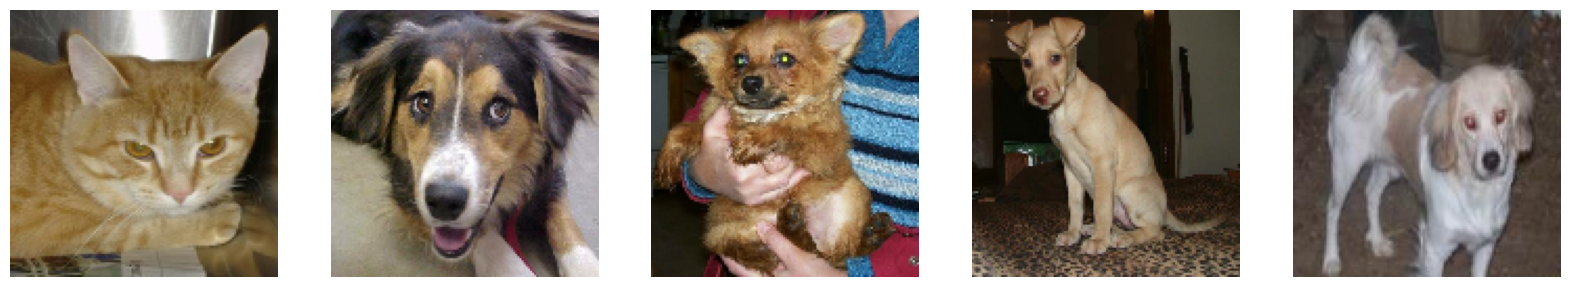

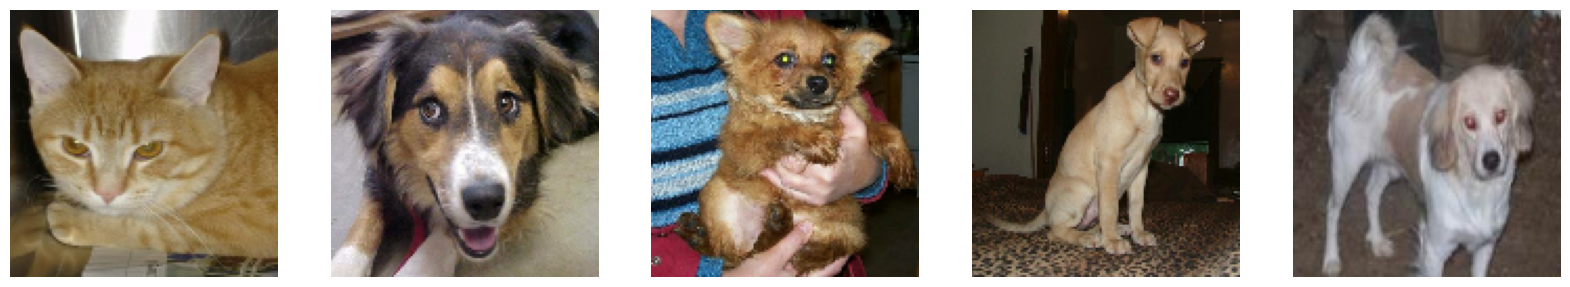

In [10]:
# Create data augmentation layer
class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self):
        super(DataAugmentation, self).__init__()
        self.augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            #layers.RandomRotation(0.05),
            #layers.RandomZoom(0.05),
            layers.RandomContrast(0.0)
        ])

    def call(self, inputs, training=None):
        if training:
            return self.augmentation(inputs, training=training)
        return inputs

data_augmentation = DataAugmentation()

# Check augmented images
for images, labels in dataset_train.take(1):
    plotimages(images.numpy()[:5])
    augmented_images = data_augmentation(images, training=True)
    plotimages(augmented_images.numpy()[:5])
    
    labels = labels.numpy()[:5]
    for index, l in enumerate(labels):
        if l == 1:
            print(f"Photo {index}: dog")
        elif l == 0:
            print(f"Photo {index}: cat")

## Retrain the Model

In [13]:
from tensorflow.keras.regularizers import l2

def Mynew_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT):
  model = tf.keras.models.Sequential([
    layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    data_augmentation,

    layers.Conv2D(8, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
  ])

  opt = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
          loss='binary_crossentropy',
          metrics=['accuracy'])

  return model

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation               │ (None, 128, 128, 3)    │             0 │
│ (DataAugmentation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,291,169 (16.37 MB)

 Trainable params: 4,290,705 (16.37 MB)

 Non-trainable params: 464 (1.81 KB)

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.5820 - loss: 2.0522 - val_accuracy: 0.4980 - val_loss: 0.8786
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 103s 330ms/step - accuracy: 0.6817 - loss: 0.6587 - val_accuracy: 0.6817 - val_loss: 0.6399
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 112s 356ms/step - accuracy: 0.7252 - loss: 0.5957 - val_accuracy: 0.6392 - val_loss: 0.7384
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 229ms/step - accuracy: 0.7410 - loss: 0.5627 - val_accuracy: 0.6490 - val_loss: 0.7012
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 62s 196ms/step - accuracy: 0.7615 - loss: 0.5305 - val_accuracy: 0.7690 - val_loss: 0.5152
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - accuracy: 0.7790 - loss: 0.5007 - val_accuracy: 0.7418 - val_loss: 0.5303
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 64s 202ms/step - accuracy: 0.7919 - loss: 0.4731 - val_accuracy: 0.7410 - val_loss: 0.5796
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 219ms/step - accuracy: 0.8000 - loss:

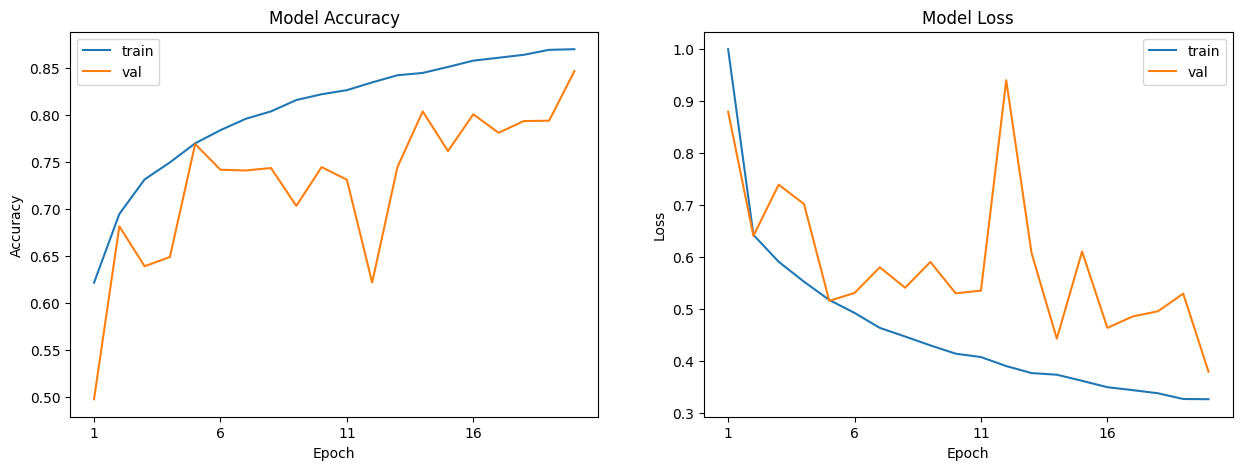

In [14]:
tf.random.set_seed(42)
new_model=Mynew_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT)
new_model.summary()
new_hist=new_model.fit(dataset_train, epochs=20, validation_data=dataset_test)
plot_model_history(new_hist)

In [ ]:
# Evaluate performance on validation set
loss, accuracy = model.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

y_preds = []
y_labels = []
y_features = []

# Loop through dataset_test to make predictions and store labels for comparison
for features, labels in dataset_test:
    predictions = new_model.predict(features, verbose=0)
    y_preds.extend([1 if pred > 0.5 else 0 for pred in predictions.flatten()])
    y_labels.extend(labels.numpy().flatten())
    y_features.extend(features.numpy())

# Create confusion matrix
confusion_mtx = confusion_matrix(y_labels, y_preds)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
plotimages(y_features[:5])
print("Predictions:", y_preds[:5])
print("True Labels:", y_labels[:5])

plotimages(y_features[5:10])
print("Predictions:", y_preds[5:10])
print("True Labels:", y_labels[5:10])


##### This model is performing roughly the same as it did in the original notebook. Since it is using pre-seperated input data instead of the datasets prepared for the first model, its hard to know if that data also has issues with data distribution.



## Transfer Learning - VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

In [ ]:
vgghist = vggmodel.fit(dataset_train, epochs=40, validation_data=dataset_test)

In [ ]:
vggmodel.save("C:/Users/caleb/OneDrive/Documents/Coding Projects/Deep-Learning/Resources/Image-Classification-CNN-and-VGG/models/vggmodel.keras")

## Evaluation

In [ ]:
plot_model_history(vgghist)
loss, accuracy = vggmodel.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
vgg_preds = []
vgg_labels = []

# Loop through dataset_test to make predictions and store labels for comparison
for features, labels in dataset_test:
    predictions = vggmodel.predict(features, verbose=0)
    vgg_preds.extend([1 if pred > 0.5 else 0 for pred in predictions.flatten()])
    vgg_labels.extend(labels.numpy().flatten())  # Assuming labels is a tensor

# Create Confusion Matrix
confusion_mtx = confusion_matrix(vgg_labels, vgg_preds)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(vgg_labels, vgg_preds, target_names=['0','1'])
print(report)

##### With improvements to the first model, it now slightly outperforms the VGG16 model above. This model might be underperforming due to the smaller learning rate that is being used or it may just need to be trained for more epochs since it's a much larger model, but the extensive training time makes it difficult to test other variations.